# Model derived using transfer learning



In [7]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

GPU is NOT AVAILABLE


## Configuration

In [8]:
import ipywidgets as widgets

# MODEL_CHARACTERISTICS
MODELS = {
    "InceptionV1" : {
        "url": "https://www.kaggle.com/models/google/inception-v1/TensorFlow2/feature-vector/2",
        "dim": 224
    },
    "InceptionV2" : {
        "url": "https://www.kaggle.com/models/google/inception-v2/TensorFlow2/feature-vector/2",
        "dim": 224
    },
    "InceptionV3" : {
        "url": "https://www.kaggle.com/models/google/inception-v3/TensorFlow2/feature-vector/2",
        "dim": 299
    },
    "MobileNetV1" : {
        "url": "https://www.kaggle.com/models/google/mobilenet-v1/TensorFlow2/100-224-feature-vector/2",
        "dim": 224
    },
    "MobileNetV2" : {
        "url": "https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/100-224-feature-vector/2",
        "dim": 224
    },
    "MobileNetV3" : {
        "url": "https://www.kaggle.com/models/google/mobilenet-v3/TensorFlow2/small-100-224-feature-vector/1",
        "dim": 224
    },
    "NasNet" : {
        "url": "https://www.kaggle.com/models/google/nasnet/TensorFlow2/large-feature-vector/2",
        "dim": 331
    },
    "NasNetMobile" : {
        "url": "https://www.kaggle.com/models/google/nasnet/TensorFlow2/mobile-feature-vector/2",
        "dim": 224
    },
    "ResNetV1" : {
        "url": "https://www.kaggle.com/models/google/resnet-v1/TensorFlow2/50-feature-vector/2",
        "dim": 224
    },
    "ResNetV2" : {
        "url": "https://www.kaggle.com/models/google/resnet-v2/TensorFlow2/50-feature-vector/2",
        "dim": 224
    },
    
}
MODEL_CFG = widgets.Dropdown(description="Model:", value='MobileNetV1', options=sorted(MODELS.keys()))
CT_CFG = widgets.FloatSlider(description="Convergenge threshold:", value=0.99, min=0.25, max=1.00, step=0.01)
DROPOUT_CFG = widgets.FloatSlider(description="Dropout (0: no dropout):", value=0, min=0.0, max=0.5, step=0.1)
MAX_STEPS_CFG = widgets.IntSlider(description="Max. training steps:", value=50, min=10, max=100, step=10)
BATCH_SIZE_CFG = widgets.IntSlider(description="Batch size:", value=168, min=32, max=500)
display(widgets.VBox([MODEL_CFG, CT_CFG, DROPOUT_CFG, MAX_STEPS_CFG, BATCH_SIZE_CFG]))

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


In [9]:
P_MODEL = MODEL_CFG.value
P_DIM = MODELS[P_MODEL]["dim"]
P_URL = MODELS[P_MODEL]["url"]
global P_CT
P_CT = CT_CFG.value
P_DROPOUT = DROPOUT_CFG.value
P_MAX_STEPS = MAX_STEPS_CFG.value
P_BATCH_SIZE = BATCH_SIZE_CFG.value
print(' Model:', P_MODEL, '\n',
      'Model - URL:', P_URL, '\n',
      'Model - dim:', P_DIM, '\n',
      'Conv. thr.:', P_CT, '\n',
      'Dropout:', P_DROPOUT, '\n',
      'Max steps:', P_MAX_STEPS, '\n',
      'Batch size:', P_BATCH_SIZE)

 Model: MobileNetV1 
 Model - URL: https://www.kaggle.com/models/google/mobilenet-v1/TensorFlow2/100-224-feature-vector/2 
 Model - dim: 224 
 Conv. thr.: 0.99 
 Dropout: 0.0 
 Max steps: 50 
 Batch size: 168


## Define train, validation and test sets

In [10]:
datagen = ImageDataGenerator(rescale=1.0/255.0)
train_dataset = datagen.flow_from_directory(
    'dset2/train',
    target_size=(P_DIM,P_DIM),
 
    batch_size=P_BATCH_SIZE,
    class_mode='sparse'
)
validation_dataset = datagen.flow_from_directory(
    'dset2/valid',
    target_size=(P_DIM,P_DIM),

    batch_size=P_BATCH_SIZE,
    class_mode='sparse'
)
test_dataset = datagen.flow_from_directory(
    'dset2/test',
    target_size=(P_DIM,P_DIM),

    batch_size=P_BATCH_SIZE,
    class_mode='sparse'
)

Found 3360 images belonging to 21 classes.
Found 420 images belonging to 21 classes.
Found 420 images belonging to 21 classes.



## Define CNN using Keras API


In [11]:
kl = hub.KerasLayer(P_URL, trainable=False, input_shape=(P_DIM, P_DIM, 3))
fl = tf.keras.layers.Dense(21, activation='softmax')

if P_DROPOUT > 0.0:
    model = tf.keras.Sequential([ kl, tf.keras.layers.Dropout(P_DROPOUT), fl])
else:
    model = tf.keras.Sequential([ kl, fl])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1024)              3228864   
                                                                 
 dense_1 (Dense)             (None, 21)                21525     
                                                                 
Total params: 3250389 (12.40 MB)
Trainable params: 21525 (84.08 KB)
Non-trainable params: 3228864 (12.32 MB)
_________________________________________________________________


## Train model

In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        global P_CT
        if logs.get('accuracy') >= P_CT:
            self.model.stop_training = True

import time

t_start = time.time()

history = model.fit(
     train_dataset,
     epochs=P_MAX_STEPS,
     validation_data=validation_dataset,
     callbacks = [CustomCallback()]
)
t_end = time.time()
print('Training time', t_end - t_start)

Epoch 1/50
20/20 [==============================] - 36s 2s/step - loss: 2.7538 - accuracy: 0.2250 - val_loss: 1.8877 - val_accuracy: 0.4714
Epoch 2/50
20/20 [==============================] - 35s 2s/step - loss: 1.4620 - accuracy: 0.6113 - val_loss: 1.3005 - val_accuracy: 0.6357
Epoch 3/50
20/20 [==============================] - 35s 2s/step - loss: 1.0564 - accuracy: 0.7259 - val_loss: 1.0680 - val_accuracy: 0.7024
Epoch 4/50
20/20 [==============================] - 34s 2s/step - loss: 0.8602 - accuracy: 0.7830 - val_loss: 0.9369 - val_accuracy: 0.7381
Epoch 5/50
20/20 [==============================] - 35s 2s/step - loss: 0.7422 - accuracy: 0.8149 - val_loss: 0.8489 - val_accuracy: 0.7548
Epoch 6/50
20/20 [==============================] - 35s 2s/step - loss: 0.6519 - accuracy: 0.8426 - val_loss: 0.7730 - val_accuracy: 0.7952
Epoch 7/50
20/20 [==============================] - 35s 2s/step - loss: 0.5841 - accuracy: 0.8598 - val_loss: 0.7218 - val_accuracy: 0.8000
Epoch 8/50
20/20 [==

## Plot training evolution

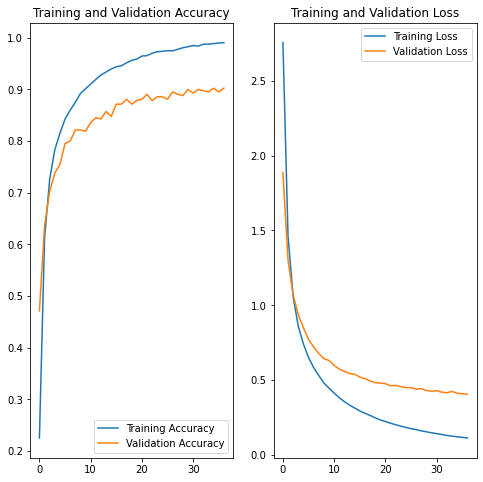

In [13]:
from  matplotlib import pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Save model and convert it to TFLite format

In [14]:
model.save('models/' + P_MODEL)
converter = tf.lite.TFLiteConverter.from_saved_model('models/' + P_MODEL) # path to the SavedModel directory
tflite_model = converter.convert()
with open('models/' + P_MODEL + '.tflite', 'wb') as f:
      f.write(tflite_model)

INFO:tensorflow:Assets written to: models/MobileNetV1/assets


INFO:tensorflow:Assets written to: models/MobileNetV1/assets
2025-01-21 09:48:48.328920: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-01-21 09:48:48.328947: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-01-21 09:48:48.329614: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: models/MobileNetV1
2025-01-21 09:48:48.335590: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-01-21 09:48:48.335626: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: models/MobileNetV1
2025-01-21 09:48:48.351186: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2025-01-21 09:48:48.358014: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2025-01-21 09:48:48.556496: I tensorflow/cc/saved_model/loader.cc:215] Running initial

In [19]:
label_map = (train_dataset.class_indices)
label_map

{'AH': 0,
 'AT_CA': 1,
 'AT_CH': 2,
 'AT_I1': 3,
 'AT_I2': 4,
 'AT_M': 5,
 'AT_O1': 6,
 'AT_O2': 7,
 'AT_S': 8,
 'CN': 9,
 'DC': 10,
 'DF': 11,
 'DG': 12,
 'ES': 13,
 'GL': 14,
 'HA': 15,
 'SA': 16,
 'SN': 17,
 'SS': 18,
 'TMA': 19,
 'TS': 20}

## Calculate accuracy and loss for validation and test datasets

In [15]:
loss, accuracy = model.evaluate(validation_dataset)

print("VALIDATION - loss {}, accuracy {}".format(loss,accuracy))

loss, accuracy = model.evaluate(test_dataset)

print("TEST - loss {}, accuracy {}".format(loss,accuracy))

3/3 [==============================] - 4s 1s/step - loss: 0.4056 - accuracy: 0.9024
VALIDATION - loss 0.4056427478790283, accuracy 0.9023809432983398
3/3 [==============================] - 4s 1s/step - loss: 0.3792 - accuracy: 0.9024
TEST - loss 0.37920358777046204, accuracy 0.9023809432983398
